In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Path to your main folder
dataset_path = "/content/drive/MyDrive/dataset-20250614T060517Z-1-001/dataset"

# Load with train/validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 540 files belonging to 18 classes.
Using 432 files for training.
Found 540 files belonging to 18 classes.
Using 108 files for validation.
Classes: ['beaming-face', 'cloud', 'face-spiral', 'flushed-face', 'grimacing-face', 'grinning-face', 'grinning-squinting', 'heart', 'pouting-face', 'raised-eyebrow', 'relieved-face', 'savoring-food', 'smiling-heart', 'smiling-horns', 'smiling-sunglasses', 'smiling-tear', 'smirking-face', 'tears-of-joy']


In [43]:
SAUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [44]:
from tensorflow.keras import layers, models, regularizers

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
], name="data_augmentation")

In [58]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Rescaling(1./255),

    data_augmentation,

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(18, activation='softmax')
])



In [59]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [60]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.0670 - loss: 2.9198 - val_accuracy: 0.0833 - val_loss: 2.8781
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1292 - loss: 2.8512 - val_accuracy: 0.1389 - val_loss: 2.7981
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1460 - loss: 2.7224 - val_accuracy: 0.1852 - val_loss: 2.5170
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2155 - loss: 2.5465 - val_accuracy: 0.2500 - val_loss: 2.3142
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3393 - loss: 2.1397 - val_accuracy: 0.3426 - val_loss: 2.0240
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3939 - loss: 1.8807 - val_accuracy: 0.4630 - val_loss: 1.6919
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3605 - loss: 1.8422 - val_accuracy: 0.4537 - val_loss: 1.8287
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4877 - loss: 1.5848 - val_accuracy: 0.6019 - v

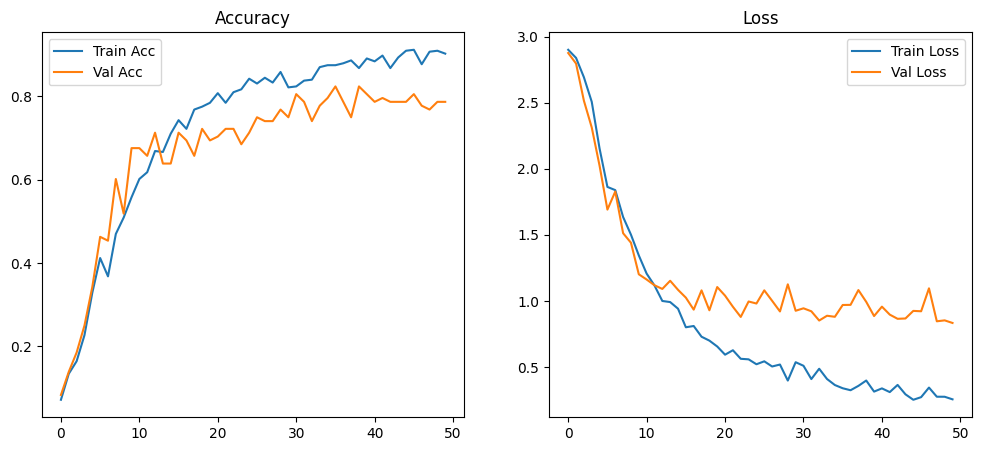

In [61]:
# Plotting accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


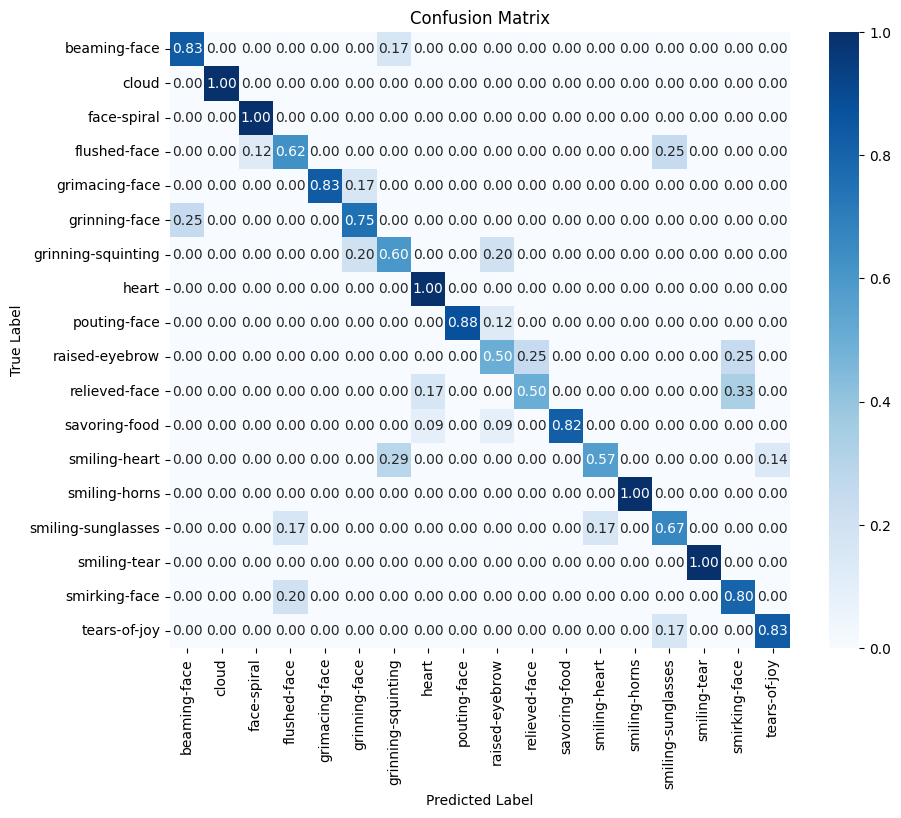

In [62]:
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:  # or val_ds
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
